# UC San Diego: Data Science in Practice - EDA Checkpoint
### Summer Session I 2023 | Instructor : C. Alex Simpkins Ph.D.

## Draft project title if you have one (can be changed later)

(This checkpoint helps you to perform your EDA on your data for your project. You can remove this text description. Consider this the next step in your final project. See the project readme for bullet points to check off in terms of details to include beyond the main section heading content below.)

# Names

- Conner Hsu
- Harshita Saha
- Sidharth Srinath
- Anastasiya Markova

<a id='research_question'></a>
# Research Question

Given clinical data for cohorts with and without diabetes, which feature most correlates to the measure of 'blood_glucose_level' for each cohort, and are they different between the cohorts?

# Setup and Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Data Cleaning

Describe your data cleaning steps here.

In [3]:
# check if there is any missing data
df.isna().sum().sum()

0

In [4]:
# check the datatypes of each column
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [5]:
# checking gender of patients
df.groupby('gender').count()['age']

gender
Female    58552
Male      41430
Other        18
Name: age, dtype: int64

In [6]:
# removing records where gender is not specified/recorded as it may affect predictions
df = df[df['gender'] != 'Other']
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [7]:
# removing records for patients less than 20
# this is because the rates of diabetes are lower in these populations
# and diabetes is less well studied as a result, and analyis based 
# on these groups might not generalizable
# https://www.cdc.gov/diabetes/data/statistics-report/newly-diagnosed-diabetes.html
# https://diabetesjournals.org/care/article/46/3/490/148482/Youth-Onset-Type-2-Diabetes-The-Epidemiology-of-an
df = df[df['age'] >= 20]
df.shape

(80321, 9)

In [8]:
# bmi labeling
bmi_bins = pd.cut(df['bmi'], [0, 18.5, 25, 30, round(df['bmi'].max())], right=False, \
                  labels=['underweight', 'healthy', 'overweight', 'obese']) 
df['bmi_label'] = bmi_bins

In [9]:
# blood_glucose labeling
bg_bins = pd.cut(df['blood_glucose_level'], [0, 90, 130, round(df['blood_glucose_level'].max())], right=False, \
                 labels=['low', 'normal', 'high'])
df['bg_label'] = bg_bins

In [10]:
# HbA1c labeling
age_bins = pd.cut(df['age'], [19, 39, 59, round(df['age'].max())], labels=['g1', 'g2', 'g3'])
df['age_label'] = age_bins

#setting up thresholds for HbA1c levels
conditions = [df['age_label']=='g1', df['age_label']=='g2', df['age_label']=='g3']
choices = [6.0, 6.1, 6.5]
HbA1c_exp = np.select(conditions, choices)
df['HbA1c_label'] = HbA1c_exp

#assigning high/normal based on the thresholds and current HbA1c levels
df['HbA1c_label'] = (df['HbA1c_level'] <= df['HbA1c_label']).replace({True:'normal', False:'high'})
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,bmi_label,bg_label,age_label,HbA1c_label
0,Female,80.0,0,1,never,25.19,6.6,140,0,overweight,high,g3,high
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,overweight,low,g2,high
2,Male,28.0,0,0,never,27.32,5.7,158,0,overweight,high,g1,normal
3,Female,36.0,0,0,current,23.45,5.0,155,0,healthy,high,g1,normal
4,Male,76.0,1,1,current,20.14,4.8,155,0,healthy,high,g3,normal


In [11]:
#reorderingthe columns
df = df[list(df.columns[:6])+['bmi_label', 'HbA1c_level', 'HbA1c_label', 'blood_glucose_level', 'bg_label', 'diabetes']]
#renaming the columns
df = df.rename(columns={"HbA1c_level": "hba1c", "HbA1c_label": "hba1c_label", "blood_glucose_level": "bg"})
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,bmi_label,hba1c,hba1c_label,bg,bg_label,diabetes
0,Female,80.0,0,1,never,25.19,overweight,6.6,high,140,high,0
1,Female,54.0,0,0,No Info,27.32,overweight,6.6,high,80,low,0
2,Male,28.0,0,0,never,27.32,overweight,5.7,normal,158,high,0
3,Female,36.0,0,0,current,23.45,healthy,5.0,normal,155,high,0
4,Male,76.0,1,1,current,20.14,healthy,4.8,normal,155,high,0


In [12]:
df0 = df[df['diabetes'] == 0]
df1 = df[df['diabetes'] == 1]

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [13]:
df.describe()

,age,hypertension,heart_disease,bmi,hba1c,bg,diabetes
count,80321.000000,80321.000000,80321.000000,80321.000000,80321.000000,80321.000000,80321.000000
mean,49.782946,0.093064,0.049003,28.711241,5.555272,139.280101,0.104506
std,17.478788,0.290524,0.215876,6.057741,1.090123,41.974772,0.305917
min,20.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,35.000000,0.000000,0.000000,25.700000,4.800000,100.000000,0.000000
50%,49.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,63.000000,0.000000,0.000000,30.750000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,91.820000,9.000000,300.000000,1.000000


In [14]:
# proportion of 'hypertension', 'heart_disease', 'diabetes' by gender
#df.groupby(['gender']).agg('mean')[['hypertension', 'heart_disease', 'diabetes']]
list(df.columns)

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'smoking_history',
 'bmi',
 'bmi_label',
 'hba1c',
 'hba1c_label',
 'bg',
 'bg_label',
 'diabetes']

In [15]:
df.dtypes

gender               object
age                 float64
hypertension          int64
heart_disease         int64
smoking_history      object
bmi                 float64
bmi_label          category
hba1c               float64
hba1c_label          object
bg                    int64
bg_label           category
diabetes              int64
dtype: object

## Bar Charts and Box Plots

/var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_14569/2231732598.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df.groupby('heart_disease')['hypertension', 'diabetes'].mean()


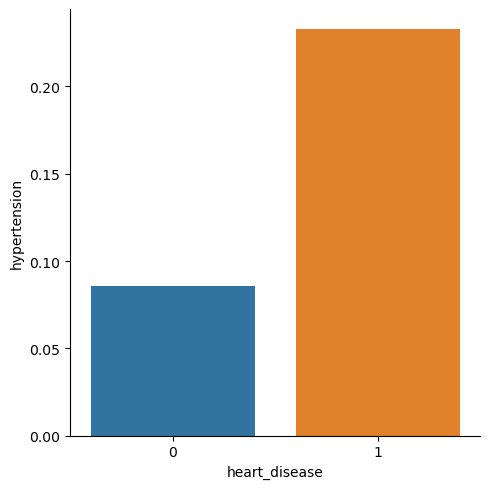

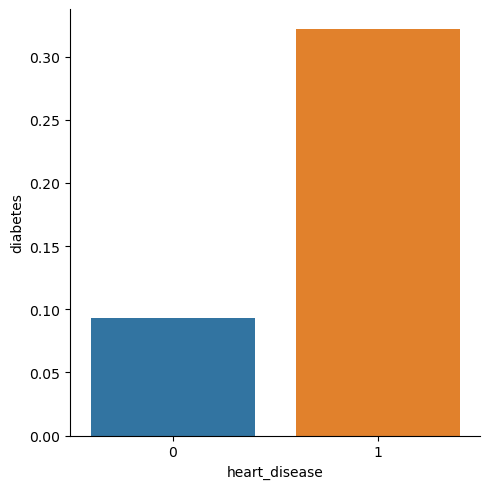

In [16]:
tmp = df.groupby('heart_disease')['hypertension', 'diabetes'].mean()
tmp.reset_index(inplace=True)
sns.catplot(data=tmp, kind="bar", x='heart_disease', y="hypertension")
sns.catplot(data=tmp, kind="bar", x='heart_disease', y='diabetes')

/var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_14569/3079984522.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df.groupby('hypertension')['heart_disease', 'diabetes'].mean()


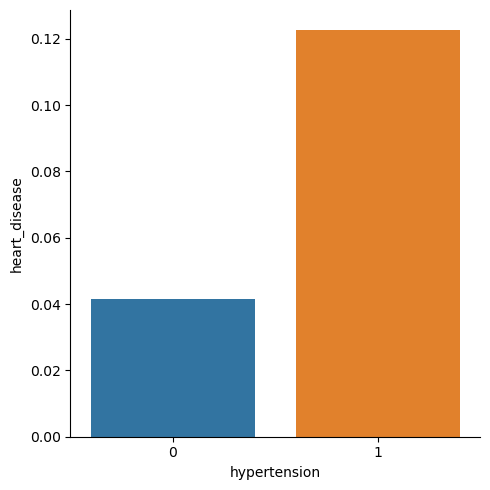

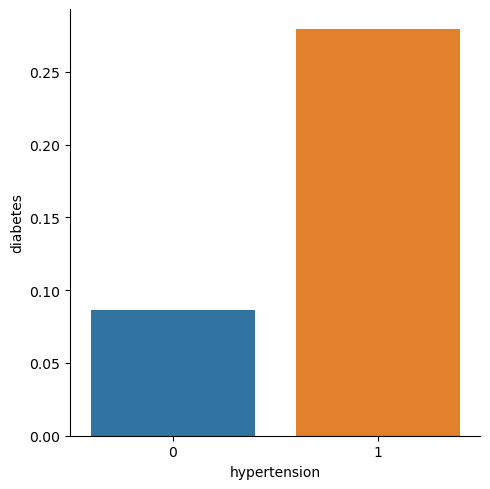

In [17]:
# proportion of 'heart_disease', 'diabetes' by hypertension status
tmp = df.groupby('hypertension')['heart_disease', 'diabetes'].mean()
tmp.reset_index(inplace=True)
sns.catplot(data=tmp, kind="bar", x='hypertension', y="heart_disease")
sns.catplot(data=tmp, kind="bar", x='hypertension', y='diabetes')

## Regression Plots

<Axes: xlabel='bmi', ylabel='bg'>

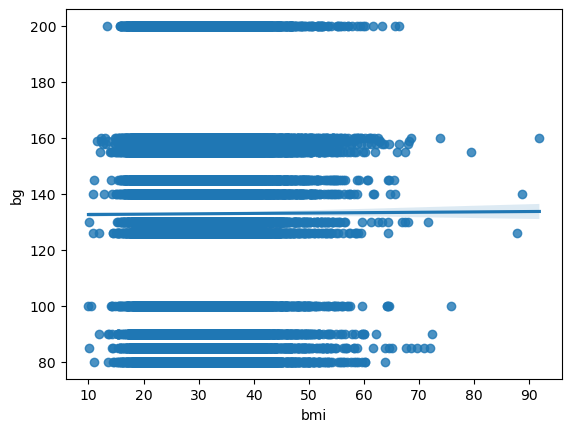

In [18]:
sns.regplot(x='bmi', y='bg', data=df[df['diabetes'] == 0])

<Axes: xlabel='bmi', ylabel='bg'>

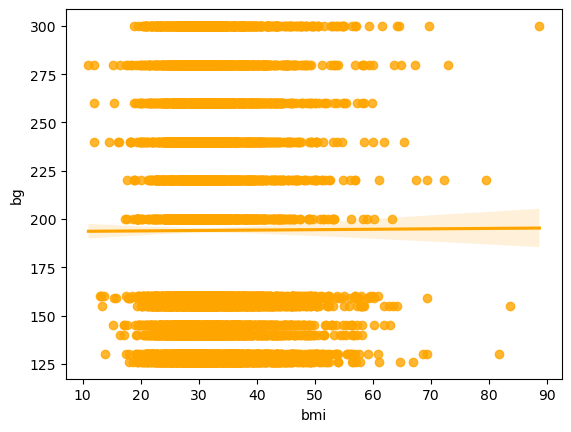

In [19]:
sns.regplot(x='bmi', y='bg', data=df[df['diabetes'] == 1], color='orange')

<Axes: xlabel='hba1c', ylabel='bg'>

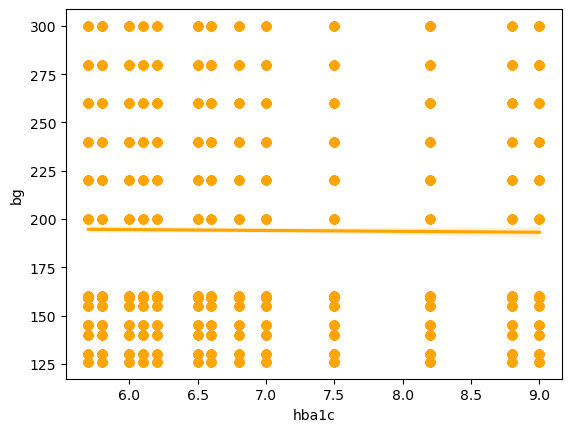

In [20]:
sns.regplot(x='hba1c', y='bg', data=df[df['diabetes'] == 1], color='orange')

<Axes: xlabel='hba1c', ylabel='bg'>

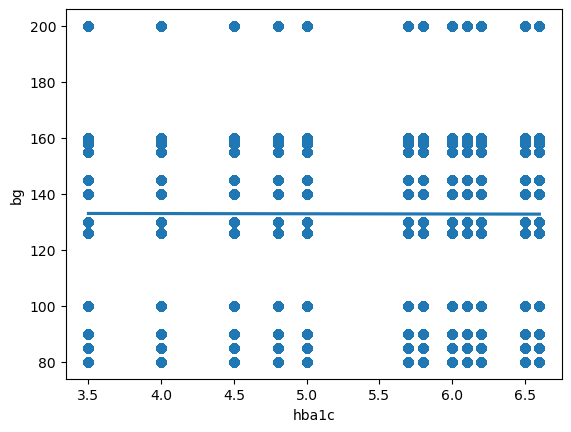

In [21]:
sns.regplot(x='hba1c', y='bg', data=df[df['diabetes'] == 0])

<Axes: xlabel='age', ylabel='bg'>

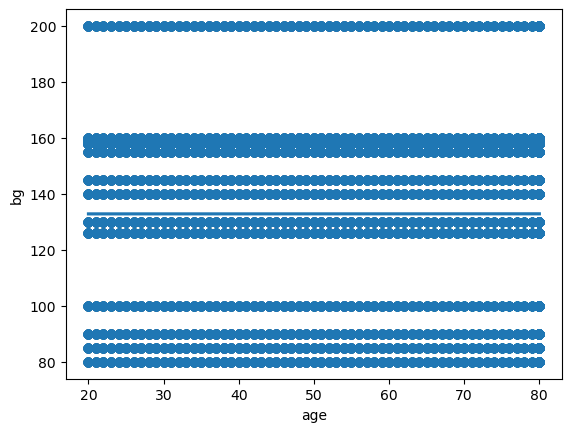

In [22]:
sns.regplot(x='age', y='bg', data=df[df['diabetes'] == 0])

<Axes: xlabel='age', ylabel='bg'>

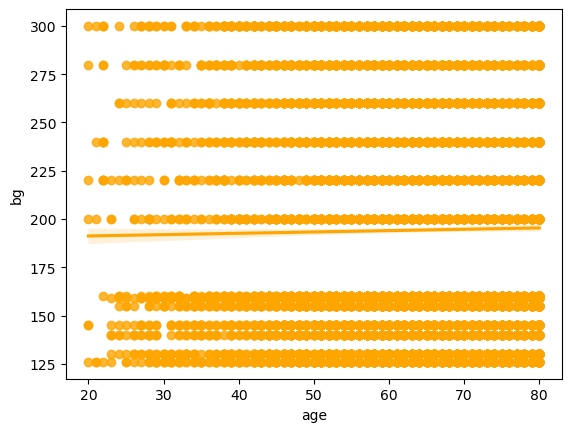

In [23]:
sns.regplot(x='age', y='bg', data=df[df['diabetes'] == 1], color='orange')

## A/B Testing

#### Preparing

In [26]:
#resample the diabetes patients so that our data is less skewed
n = df.shape[0] - (df['diabetes'] == 1).sum()
#since the data has many more patients without diabetes than with diabetes this can skew our A/B, so we took a random
#sample of the the people with diabetes to create an even split of those with and without diabetes.
sapmle_df = df[df['diabetes'] == 1].sample(n=n, replace=True)
sample_df = pd.concat([sapmle_df, df[df['diabetes'] == 0]], ignore_index=True)

In [27]:
#finding average values of all numeric columns for people with and without diabetes
df_observed = sample_df.groupby('diabetes')['bg', 'hba1c', 'bmi', 'age'].mean()

#difference in means
diffs = abs(df_observed.diff(axis=0))
diffs

/var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_14569/3032017159.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_observed = sample_df.groupby('diabetes')['bg', 'hba1c', 'bmi', 'age'].mean()


,bg,hba1c,bmi,age
diabetes,,,,
0,NaN,NaN,NaN,NaN
1,61.459077,1.53057,3.72797,13.079664


In [28]:
#This is the function to find absolute difference in means
def abs_diff_means(df, col):
    means = df.groupby('diabetes')[col].mean()
    diff = (abs(means.diff()))
    return diff.loc[1]

In [29]:
#This fucntion performs a permutation test
def permutation(df, col):
    copy = df[['diabetes', col]]
    diffs = []
    for i in range(100):
        copy['diabetes'] = np.random.permutation(copy['diabetes'])
        diffs.append(abs_diff_means(copy, col))

    return diffs


#### Blood Glucose Levels

Null: The `blood glucose` levels of patients with and without diabetes have the same distribution

Alternative: The `blood glucose` levels of the patients with and without diabetes come from different distributions

In [30]:
bg_observed = diffs.iloc[1,0]

[Text(0.5, 1.0, 'Distribution of Blood Glucose Levels For Diabetes/Non-Diabetes Patients')]

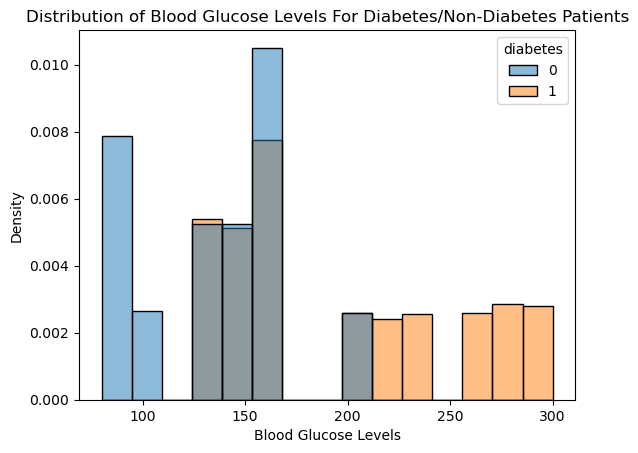

In [31]:
#Plot the Distributions of Blood Glucose Levels for Diabetes and Non-Diabetes Patients
ax = plt.subplot()
ax.set_xlabel('Blood Glucose Levels')
sns.histplot(x='bg', hue = 'diabetes', data=sample_df, stat='density', kde=False, bins=15).set(title='Distribution of Blood Glucose Levels For Diabetes/Non-Diabetes Patients')

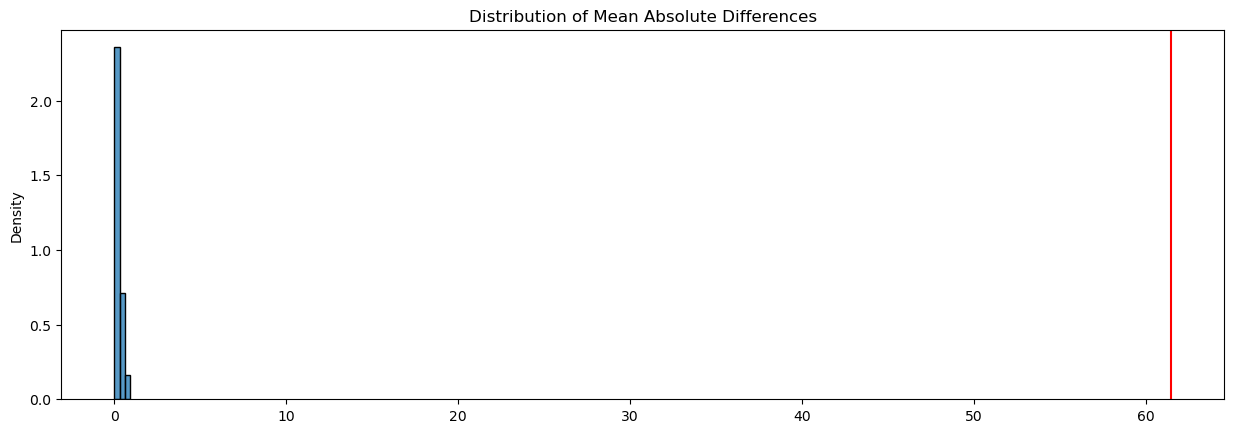

In [32]:
#we find the results of our permutation test and plot them
fig1, ax1 = plt.subplots()
perm_diffs_bg = permutation(sample_df, 'bg')
sns.histplot(data = perm_diffs_bg, stat='density', bins=3).set(title='Distribution of Mean Absolute Differences')
plt.axvline(bg_observed, color='red')
ax.set_xlabel('Absolute Difference in Means')
fig1.set_figwidth(15) 


In [33]:
#this calculates the p-value for the permutation test on blood glucose level
p_value_bg = (perm_diffs_bg >= bg_observed).sum()
p_value_bg

0

Conclustion: Based on our permutation test we conclude the blood_glucose levels of Diabetes and Non-diabetes patients seem to come from different distributions. We reject the null with 0.01 significance level since out p-value of 0.0 is less than 0.01

#### HbA1c Levels

Null: The `hba1c` levels of patients with and without diabetes have the same distribution

Alternative: The `hba1c` levels of the patients with and without diabetes come from different distributions


[Text(0.5, 1.0, 'Distribution of HbA1c Levels For Diabetes/Non-Diabetes Patients')]

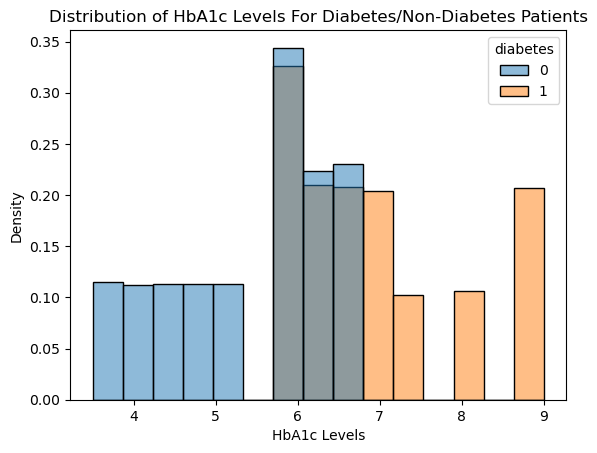

In [34]:
#Distribution of the HbA1c Levels for people with and without Diabetes
ax = plt.subplot()
ax.set_xlabel('HbA1c Levels')
sns.histplot(x='hba1c', hue = 'diabetes', data=sample_df, stat='density', kde=False, bins=15).set(title="Distribution of HbA1c Levels For Diabetes/Non-Diabetes Patients")

In [35]:
#Our observed test statistic for hba1c levels
hba1c_observed = diffs.iloc[1,1]

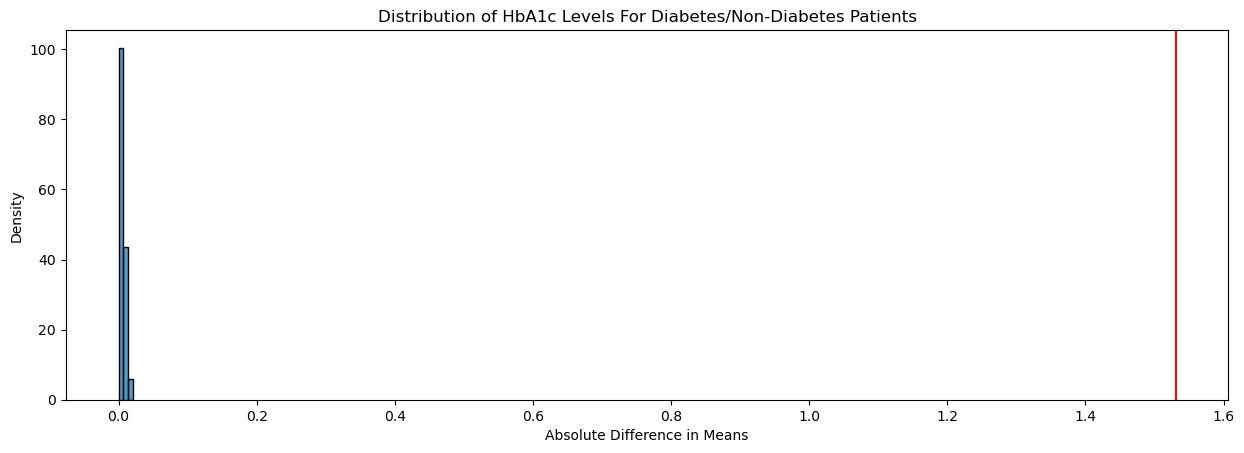

In [36]:
#The result of our permutation tests
perm_diffs = permutation(sample_df, 'hba1c')
fig2, ax2 = plt.subplots()
ax2.set_xlabel('Absolute Difference in Means')
sns.histplot(data = perm_diffs, stat='density', bins=3).set(title='Distribution of HbA1c Levels For Diabetes/Non-Diabetes Patients')
plt.axvline(hba1c_observed, color='red')
fig2.set_figwidth(15) 

In [37]:
#This is the p value for hba1c levels
p_value_bg = (perm_diffs >= hba1c_observed).sum()
p_value_bg

0

Conclustion: Based on our permutation test we conclude the hba1c levels of Diabetes and Non-diabetes patients seem to come from different distributions. We reject the null with 0.01 significance level since out p-value of 0.0 is less than 0.01

#### BMI Levels

Null: The `bmi` levels of patients with and without diabetes have the same distribution

Alternative: The `bmi` levels of the patients with and without diabetes come from different distributions

[Text(0.5, 1.0, 'Distribution of BMI Levels For Diabetes/Non-Diabetes Patients')]

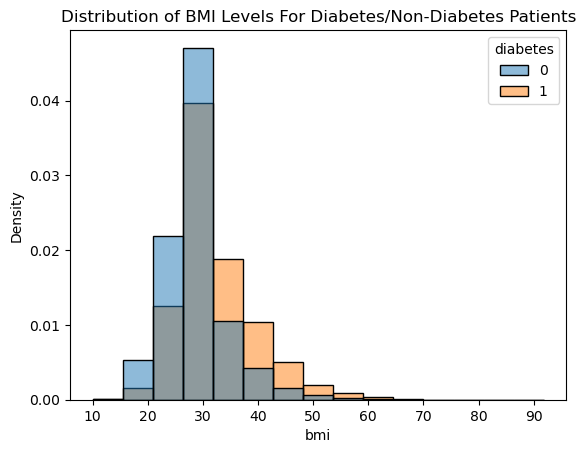

In [38]:
sns.histplot(x='bmi', hue = 'diabetes', data=sample_df, stat='density', kde=False, bins=15).set(title='Distribution of BMI Levels For Diabetes/Non-Diabetes Patients')

In [39]:
bmi_observed = diffs.iloc[1,2]

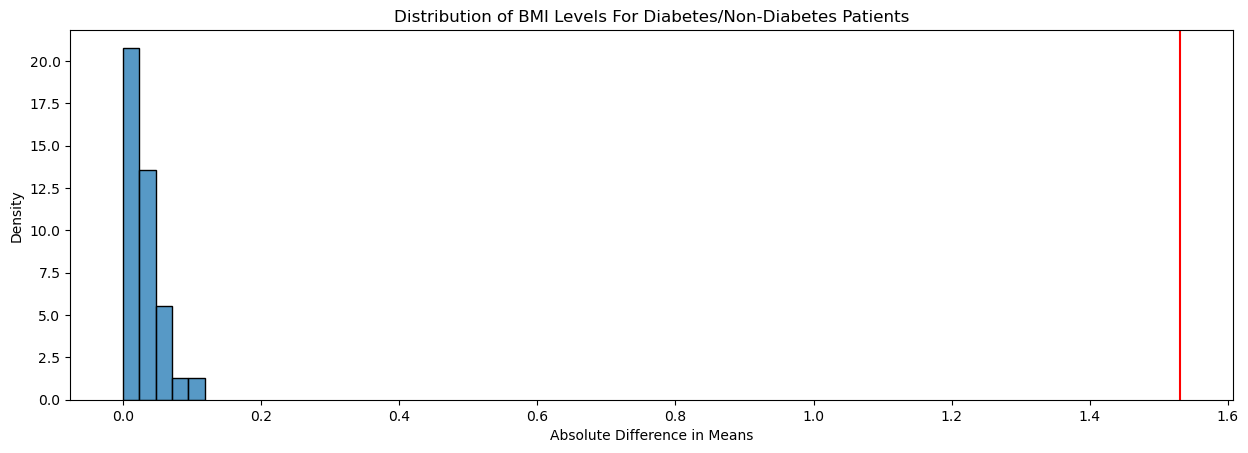

In [40]:
perm_diffs = permutation(sample_df, 'bmi')
fig3, ax3 = plt.subplots()
ax3.set_xlabel('Absolute Difference in Means')
sns.histplot(data = perm_diffs, stat='density', bins=5).set(title='Distribution of BMI Levels For Diabetes/Non-Diabetes Patients')
plt.axvline(hba1c_observed, color='red')
fig3.set_figwidth(15) 

In [41]:
p_value_bg = (perm_diffs >= bmi_observed).sum()
p_value_bg

0

Conclustion: Based on our permutation test we conclude the bmi levels of Diabetes and Non-diabetes patients seem to come from different distributions. We reject the null with 0.01 significance level since out p-value of 0.0 is less than 0.01

#### Ages

Null: The `age` of patients with and without diabetes have the same distribution

Alternative: The `age` of the patients with and without diabetes come from different distributions

[Text(0.5, 1.0, 'Distribution of Ages For Diabetes/Non-Diabetes Patients')]

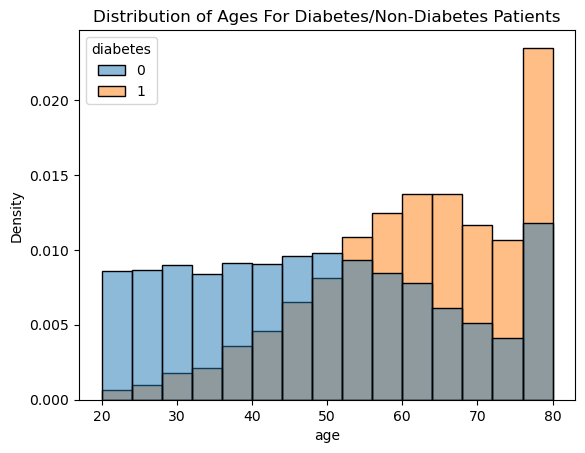

In [42]:
sns.histplot(x='age', hue = 'diabetes', data=sample_df, stat='density', kde=False, bins=15).set(title="Distribution of Ages For Diabetes/Non-Diabetes Patients")

In [43]:
age_observed = diffs.iloc[1, 3]
age_observed

13.079664103883104

In [44]:
p_value_bg = (perm_diffs >= age_observed).sum()
p_value_bg

0

Conclustion: Based on our permutation test we conclude the ages of Diabetes and Non-diabetes patients seem to come from different distributions. We reject the null with 0.01 significance level since out p-value of 0.0 is less than 0.01

### Relationships Between Different Varibles

Since we are trying to predict which features correlates with blood_glucose the most we wanted to see some of the relationships between blood_glucose and other variables individually.

<Axes: xlabel='bg', ylabel='diabetes'>

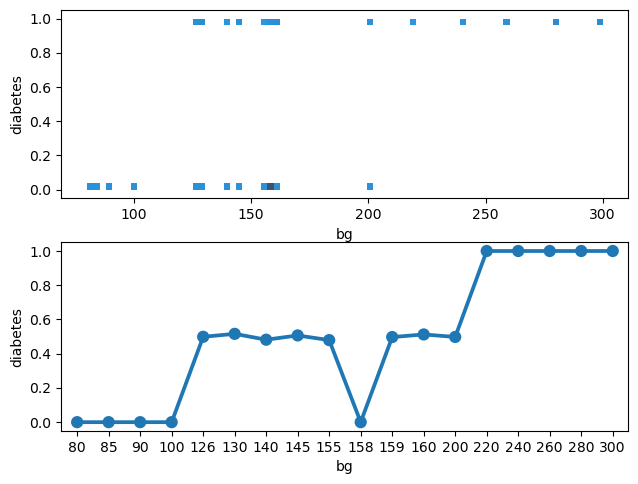

In [45]:
fig, ax = plt.subplots(nrows=2)
fig.tight_layout()
sns.pointplot(x='bg', y='diabetes', data=sample_df, ax=ax[1])
sns.histplot(x='bg', y='diabetes', data=sample_df, ax=ax[0])

This plot shows the relationship between diabetes and blood_glucose levels. Since diabetes is a binary variable, we can see that there are some values of blood_glucose that occur in both diabetes and non-diabetes patients (range from 100, 200). There are also values that of blood glucose that only occur in the diabetes patients (>200), knowing this information we can analyze other variables in relation to blood glucose level and put it into perspective of diabetes and non-diabetes patients.

<Axes: xlabel='bg', ylabel='hypertension'>

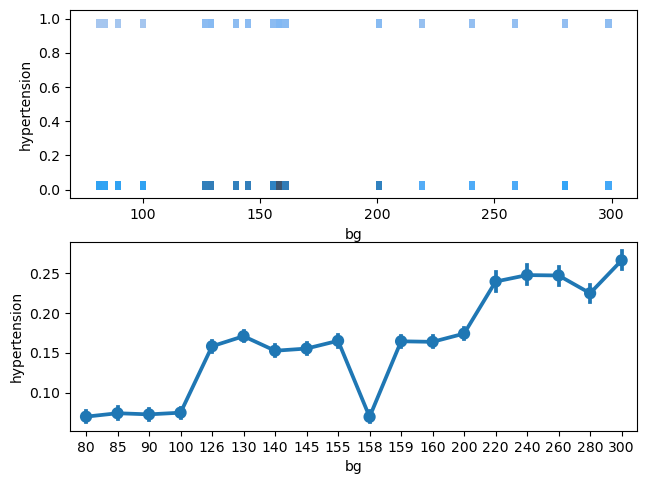

In [46]:
fig, ax = plt.subplots(nrows=2)
fig.tight_layout()
sns.pointplot(x='bg', y='hypertension', data=sample_df, ax=ax[1])
sns.histplot(x='bg', y='hypertension', data=sample_df, ax=ax[0])


Here we see that hypertension occurs in people of all blood glucose levels however, on average as the blood glucose level increases the higher the likelihood that the person has hypertension.

<Axes: xlabel='bg', ylabel='heart_disease'>

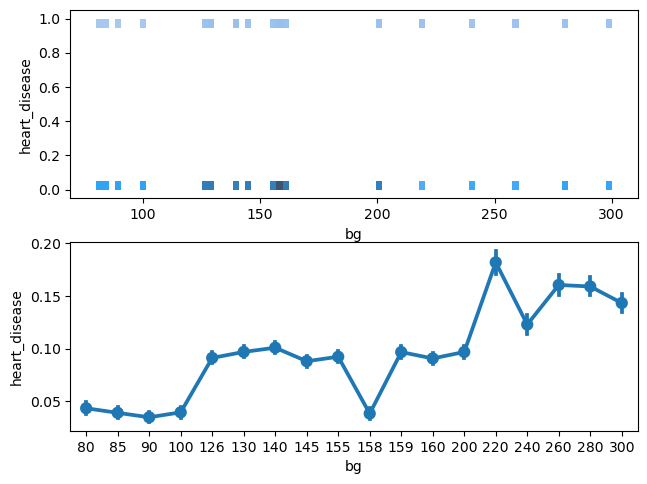

In [47]:
fig, ax = plt.subplots(nrows=2)
fig.tight_layout()
sns.pointplot(x='bg', y='heart_disease', data=sample_df, ax=ax[1])
sns.histplot(x='bg', y='heart_disease', data=sample_df, ax=ax[0])

We see a similar trend in heart_disease. Heart disease occurs in patients of all ages, however, as the blood glucose increases the likelihood of the heart_disease increases as well. Looking back at our bg vs. diabetes graph, we know that the non-diabetes patients fall within the 80 to 200 blood glucose range. Heart disease and hypertension levels within that range tend to increase. Same goes for the range over 200, so we would want to explore both of these features as predictors of blood glucose levels in diabetes and non-diabetes patients

Another plot we want to explore is age vs. bg levels. As you can see below, the blood glucose levels increase as people age, there is a strong positive correlation.

<Axes: xlabel='age', ylabel='bg'>

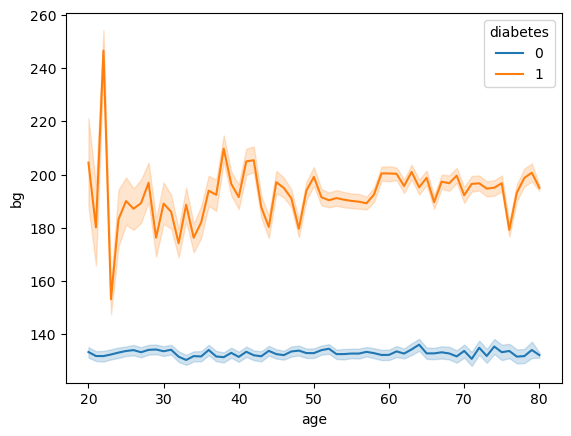

In [70]:
sns.lineplot(x='age', y='bg', hue='diabetes', data=sample_df)

## Using Linear Regression to find the best features

#### How well does age predict blood glucose levels?

In [52]:
df0 = df[df['diabetes'] == 0]
df1 = df[df['diabetes'] == 1]

On the whole dataset

In [54]:
#split the data into train and test
X = np.array(sample_df['age']).reshape((-1, 1))
y = np.array(sample_df['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#fit and predict
reg = LinearRegression().fit(X_train, y_train)
reg.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

55.72502293566959

On the diabetes patients

In [55]:
#split the data into train and test
X = np.array(df1['age']).reshape((-1, 1))
y = np.array(df1['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#fit and predict
reg = LinearRegression().fit(X_train, y_train)
reg.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

58.5149290810686

On the non-diabetes patients

In [56]:
#split the data into train and test
X = np.array(df0['age']).reshape((-1, 1))
y = np.array(df0['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#fit and predict
reg = LinearRegression().fit(X_train, y_train)
reg.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

34.32799194869588

#### Rating Features On the Whole Dataset

In [74]:
#define necessary features
features = ['age', 'bmi', 'hba1c']
#splite into train and test
X = np.array(sample_df.loc[:,features]).reshape((-1, 3))
y = np.array(sample_df['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#standardize all of the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#predict with linear regression
model = LinearRegression()
model.fit(X_train, y_train)
model.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

53.08012294166657

In [75]:
coefficients = model.coef_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
2,hba1c,15.250098
0,age,8.809847
1,bmi,6.025708


#### Rating Features on the non-diabetes patients

In [66]:
#define the features
features = ['age', 'bmi', 'hba1c']
#split into train and test sets
X = np.array(df0.loc[:,features]).reshape((-1, 3))
y = np.array(df0['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#fit and predict to linear regression
model = LinearRegression()
model.fit(X_train, y_train)
model.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

34.33034188127072

In [67]:
coefficients = model.coef_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
feature_importance.sort_values('Importance', ascending=False)

,Feature,Importance
2,hba1c,0.139120
1,bmi,0.118313
0,age,0.097183


#### Rating Features on the diabetes patients

In [64]:
#define the features
features = ['age', 'bmi', 'hba1c']
#split into train and test sets
X = np.array(df1.loc[:,features]).reshape((-1, 3))
y = np.array(df1['bg'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#fit and predict to linear regression
model = LinearRegression()
model.fit(X_train, y_train)
model.predict(X_test)
#rmse
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

58.59826710580004

In [65]:
coefficients = model.coef_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
feature_importance.sort_values('Importance', ascending=False)

,Feature,Importance
0,age,1.798097
1,bmi,1.667859
2,hba1c,0.566682


## PCA

### Whole dataset

In [78]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['age', 'hypertension', 'heart_disease', 'bmi', 'hba1c', 'bg']

data_all = StandardScaler().fit_transform(df.loc[:, features].values) # normalizing the features

pca_all = PCA()
PC_all = pca_all.fit_transform(data_all)

pca_all.explained_variance_ratio_

array([0.32826218, 0.24331715, 0.22604381, 0.20237687])

In [79]:
abs(pca_all.components_[0])

array([0.41963761, 0.59549111, 0.35285292, 0.58718774])

From greatest to least: `age`, `hypertension`, `heart_disease`, `bg`, `hba1c`, `bmi`

In the entire dataset, `age` is the most dominant feature in the principle component with the largest eigenvalue. 

### Non diabetic

In [71]:
data_nondiabetic = StandardScaler().fit_transform(df0.loc[:, features].values) # normalizing the features

pca_nondiabetic = PCA()
PC_nondiabetic = pca_nondiabetic.fit_transform(data_nondiabetic)

pca_nondiabetic.explained_variance_ratio_

array([0.22734364, 0.17067367, 0.16694338, 0.1662953 , 0.14568562,
       0.12305839])

In [72]:
abs(pca_nondiabetic.components_[0])

array([6.32994518e-01, 5.41993670e-01, 5.33007257e-01, 1.46498483e-01,
       1.41142694e-03, 5.18379547e-04])

From greatest to least: `age`, `hypertension`, `heart_disease`, `bmi`, `hba1c`, `bg`

In the nondiabetic subset of the dataset, `age` is the most dominant feature in the principle component with the largest eigenvalue. `hypertension` and `heart_disease` are also quite large.

### Diabetic

In [73]:
data_diabetic = StandardScaler().fit_transform(df1.loc[:, features].values) # normalizing the features

pca_diabetic = PCA()
PC_diabetic = pca_diabetic.fit_transform(data_diabetic)

pca_diabetic.explained_variance_ratio_

array([0.22234018, 0.17286144, 0.16833244, 0.16519725, 0.15253172,
       0.11873698])

In [74]:
abs(pca_diabetic.components_[0])

array([0.6764846 , 0.17709617, 0.51460062, 0.49384099, 0.03775497,
       0.0297888 ])

From greatest to least: `age`, `heart_disease`, `bmi`, `hypertension`, `hba1c`, `bg`

In the diabetic subset of the dataset, `age` is the most dominant feature in the principle component with the largest eigenvalue. `hypertension` and `bmi` are also quite large.